## E-Net - Efficient Neural Network

Reprodução do modelo E-net com o intuito de utiliza-lo para tarefa de detecção de estradas (região navegável) a fim de ser utilizado em carro autônomo em escala. A arquitetura da rede foi dividido em blocos principais (bottlenecks) havendo quatro tipos: downsampling, regular/dilated, upsampling e asymmetric. Além disso, ainda existe o bloco inicial. Cada qual possui sua própria implementação em .py, sendo o E_Net.py a implementação do modelo em si onde é chamado os blocos.

In [1]:
#Importando módulos necessários
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision import models
from torchsummary import summary
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter

In [2]:
#Importando implementação da arquitetura da rede E-Net
from E_Net import ENet

In [3]:
#Função utilizada para realizar a inicialização dos pesos da camadas
#convolucionais seguindo distribuição normal com média 0
def _initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(mean=0, std=0.02)

In [4]:
#Função utilizada para ler dataset
def load_dataset(data_path, grayscale):
    if grayscale is True:
        transf = transforms.Compose([transforms.Grayscale(num_output_channels=1),transforms.ToTensor()])
    else:
        transf = transforms.ToTensor()
    dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transf
    )
    return dataset

In [5]:
#Função utilizada para printar sumário do modelo
def print_models():
    print("E-Net model: \n\n")
    #Queremos um canal na saída
    E_net = ENet(1)
    E_net.apply(_initialize_weights)
    E_net.cuda()
    summary(E_net, (3, 512, 512))

In [7]:
#Printando sumário do modelo
print_models()

E-Net model: 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 13, 256, 256]             364
       BatchNorm2d-2         [-1, 13, 256, 256]              26
         MaxPool2d-3          [-1, 3, 256, 256]               0
             PReLU-4         [-1, 16, 256, 256]              16
      InitialBlock-5         [-1, 16, 256, 256]               0
            Conv2d-6          [-1, 4, 256, 256]              64
       BatchNorm2d-7          [-1, 4, 256, 256]               8
             PReLU-8          [-1, 4, 256, 256]               1
            Conv2d-9          [-1, 4, 128, 128]             148
      BatchNorm2d-10          [-1, 4, 128, 128]               8
            PReLU-11          [-1, 4, 128, 128]               1
           Conv2d-12         [-1, 64, 128, 128]             256
      BatchNorm2d-13         [-1, 64, 128, 128]             128
        Dropout2d-14   

In [6]:
#Configurando caminhos para dataset

aachen_real_PATH = '../CityScapes_RoadDetection-dtl/aachen/real_img/'
aachen_mask_PATH = '../CityScapes_RoadDetection-dtl/aachen/masks_machine/'

dusseldorf_real_PATH = '../CityScapes_RoadDetection-dtl/dusseldorf/real_img/'
dusseldorf_mask_PATH = '../CityScapes_RoadDetection-dtl/dusseldorf/masks_machine/'

munster_real_PATH = '../CityScapes_RoadDetection-dtl/munster/real_img/'
munster_mask_PATH = '../CityScapes_RoadDetection-dtl/munster/masks_machine/'

ulm_real_PATH = '../CityScapes_RoadDetection-dtl/ulm/real_img/'
ulm_mask_PATH = '../CityScapes_RoadDetection-dtl/ulm/masks_machine/'

bremen_real_PATH = '../CityScapes_RoadDetection-dtl/bremen/real_img/'
bremen_mask_PATH = '../CityScapes_RoadDetection-dtl/bremen/masks_machine/'

lindau_real_PATH = '../CityScapes_RoadDetection-dtl/lindau/real_img/'
lindau_mask_PATH = '../CityScapes_RoadDetection-dtl/lindau/masks_machine/'

stuttgart_real_PATH = '../CityScapes_RoadDetection-dtl/stuttgart/real_img/'
stuttgart_mask_PATH = '../CityScapes_RoadDetection-dtl/stuttgart/masks_machine/'

In [7]:
#Configurando caminho para salvar informações
from datetime import date

name_checkpoint = "model1_" + str(date.today())

path_model_checkpoints = '../checkpoints_model/' + name_checkpoint + '.tar'

print(path_model_checkpoints)

../checkpoints_model/model1_2020-07-18.tar


In [8]:
#Carregando dataset das cidades
dataset_aachen_real = load_dataset(aachen_real_PATH, False)
dataset_aachen_mask = load_dataset(aachen_mask_PATH, True)
print("Quantidade de imagens - aachen: ",len(dataset_aachen_real))

dataset_dusseldorf_real = load_dataset(dusseldorf_real_PATH, False)
dataset_dusseldorf_mask = load_dataset(dusseldorf_mask_PATH, True)
print("Quantidade de imagens - dusseldorf: ",len(dataset_dusseldorf_real))

dataset_munster_real = load_dataset(munster_real_PATH, False)
dataset_munster_mask = load_dataset(munster_mask_PATH, True)
print("Quantidade de imagens - munster: ",len(dataset_munster_real))

dataset_ulm_real = load_dataset(ulm_real_PATH, False)
dataset_ulm_mask = load_dataset(ulm_mask_PATH, True)
print("Quantidade de imagens - ulm: ",len(dataset_ulm_real))

dataset_bremen_real = load_dataset(bremen_real_PATH, False)
dataset_bremen_mask = load_dataset(bremen_mask_PATH, True)
print("Quantidade de imagens - bremen: ",len(dataset_bremen_real))

dataset_lindau_real = load_dataset(lindau_real_PATH, False)
dataset_lindau_mask = load_dataset(lindau_mask_PATH, True)
print("Quantidade de imagens - lindau: ",len(dataset_lindau_real))

dataset_stuttgart_real = load_dataset(stuttgart_real_PATH, False)
dataset_stuttgart_mask = load_dataset(stuttgart_mask_PATH, True)
print("Quantidade de imagens - stuttgart: ",len(dataset_stuttgart_real))

Quantidade de imagens - aachen:  174
Quantidade de imagens - dusseldorf:  221
Quantidade de imagens - munster:  174
Quantidade de imagens - ulm:  95
Quantidade de imagens - bremen:  316
Quantidade de imagens - lindau:  59
Quantidade de imagens - stuttgart:  196


In [9]:
#Unindo datasets a fim de criar um dataset de treino e de validação
dataset_train_real = torch.utils.data.ConcatDataset([dataset_aachen_real,
                                               dataset_bremen_real,
                                               dataset_dusseldorf_real,
                                               dataset_stuttgart_real,
                                               dataset_ulm_real])

dataset_train_mask = torch.utils.data.ConcatDataset([dataset_aachen_mask,
                                               dataset_bremen_mask,
                                               dataset_dusseldorf_mask,
                                               dataset_stuttgart_mask,
                                               dataset_ulm_mask])

print("Dataset de treino: ", len(dataset_train_real), " imagens")

dataset_val_real = torch.utils.data.ConcatDataset([dataset_lindau_real,
                                               dataset_munster_real])

dataset_val_mask = torch.utils.data.ConcatDataset([dataset_lindau_mask,
                                               dataset_munster_mask])

print("Dataset de validação: ", len(dataset_val_real), " imagens")

Dataset de treino:  1002  imagens
Dataset de validação:  233  imagens


In [10]:
#Tamanho do lote de imagens a serem carregadas
#Cuidado - aumentando converge mais rápido, porém demanda muita GPU
batch_size = 5

#Criando classes do tipo dataloader o qual retornará iterador das 
#imagens na formatação necessária

#Treino
dataloader_train_real = torch.utils.data.DataLoader( 
    dataset_train_real,
    batch_size=batch_size)

dataloader_train_mask = torch.utils.data.DataLoader( 
    dataset_train_mask,
    batch_size=batch_size)

#Validação 
dataloader_val_real = torch.utils.data.DataLoader( 
    dataset_val_real,
    batch_size=batch_size)

dataloader_val_mask = torch.utils.data.DataLoader( 
    dataset_val_mask,
    batch_size=batch_size)

## Testes com dataset
Fazendo testes para conferir se estudo está funcionando com os datasets para depois iniciar o processo de treino. Rodando o bloco com método .next() podemos ver novas imagens sendo carregadas do dataset

In [11]:
#Criando iteradores para o data dateset de treino
iter_real = iter(dataloader_train_real)
iter_mask = iter(dataloader_train_mask)

In [12]:
'''Método next retorna array de imagens de acordo com o batch
(caso batch = 1 retorna array contendo somente uma imagem)
e a numeração da iteração atual'''
img_real, i_real = iter_real.next()
img_mask, i_mask = iter_mask.next()

print(type(img_real))
print(img_real.shape)
print(i_real)

<class 'torch.Tensor'>
torch.Size([5, 3, 512, 512])
tensor([0, 0, 0, 0, 0])


Real image:  torch.Size([3, 512, 512])
Mask image:  torch.Size([512, 512])
torch.Size([512, 512, 3])


Text(0.5, 1.0, 'Ground truth')

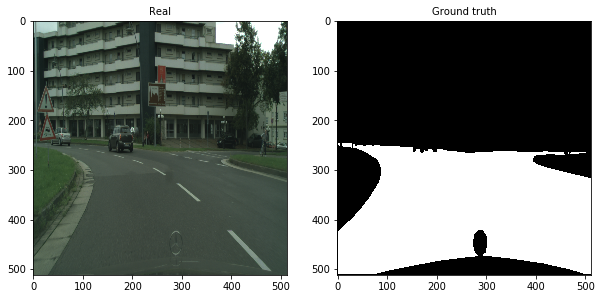

In [13]:
#Pegando imagem inicial da array de imagens como exemplo
single_img_real = img_real[0]
print("Real image: ",single_img_real.shape)
#para plotar grayscale preciso somente de duas dimensões
single_img_mask = img_mask[0][0] 
print("Mask image: ", single_img_mask.shape)
#Invertendo ordem das dimensões para consguir plotar no matplot
single_img_real = single_img_real.permute(1,2,0)
single_img_mask = single_img_mask.permute(0,1)
print(single_img_real.shape)

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,10))

ax0.imshow(single_img_real)
ax0.set_title('Real', fontsize=10)

ax1.imshow(single_img_mask, cmap='gray')
ax1.set_title('Ground truth', fontsize=10)

## Inicializando hyperparâmetros de treino
Inicializando o modelo e os parâmetros necessários para iniciar o algoritmo de treino

In [14]:
#Checo se GPU está disponível, se não irei permanecer trabalhando na CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
print(torch.cuda.get_device_name(device))

cuda
GeForce GTX 1050


In [15]:
#Criando modelo e já passando para GPU
E_Net_model = ENet(1).to(device)

#Inicializando os pesos das camadas convolucionais
E_Net_model.apply(_initialize_weights)



#Inicializando otimizador do tipo Adam (gradiente descendente com momento adaptativo)

learning_rate = 0.0005 #Taxa de aprendizagem

optimizer = torch.optim.Adam(E_Net_model.parameters(), lr=learning_rate)

#Inicializando função perda - entropia cruzada binária
criterion = nn.BCELoss()

In [16]:
#Numero de imagens totais para determinar uma época
num_data = len(dataset_train_real)

#Iterações a qual será printado resultado
batch_print = 20

#Época de inicio
epoch_ini = 0

#A quantas épocas será feito um checkpoint (salva o modelo para que
#possa ser carregado depois)
epoch_checkpoint = 1

#Quantas épocas será treinado
epoch_fin = 100

## Configurando visualização dos dados
Configurando o framework tensorboard para que seja possível visualizar dados como o progresso da perda, as imagens sendo geradas e etc.

In [17]:
#Criando configurações do tensorboard para visualização dos dados
writer_Tensorboard = SummaryWriter('../runs/'+name_checkpoint)

In [18]:
logs_base_dir = '../runs'
%load_ext tensorboard
%tensorboard --logdir {logs_base_dir}

## Algoritmo de treino
O algoritmo consiste de carregar uma quantidade de imagens definida pelo tamanho do batch em cada iteração do dataset de treino, sempre carregamos a imagem real e a máscara que é a resposta que queremos que o modelo aprenda. No inicíco de cada iteração os gradientes são resetados, a imagem real é inserida no modelo, sendo gerado uma saída. A saída e a imagem da máscara esperada são inserida na função de custo, gerando uma perda. É feito a retropropagação calculando os gradientes a partir da funçao perda e os pesos são atualizados a partir do método de otimização. Informações da perda e dados aplicados por época são printadas com frequência definida. O modelo também a salvo (checkpoints) com uma determinada frequência definida.

In [19]:
for epoch in range(epoch_ini, epoch_fin):
    
    #antes de iniciar uma época carrego os iteradores do dataset
    iter_real = iter(dataloader_train_real)
    iter_mask = iter(dataloader_train_mask)
    
    for i in range(num_data//batch_size):
        #Carrego batch de imagens
        img_real, _ = iter_real.next()
        img_mask, _ = iter_mask.next()
        
        #Passo imagens para gpu se disponível
        img_real = img_real.to(device)
        img_mask = img_mask.to(device)
        
        #Reseto gradientes acumulados da iteração anterior
        optimizer.zero_grad()
        
        #Insiro imagens reais como entrada e armazeno as saídas
        outputs = E_Net_model(img_real)
        
        #Aplico função custo para obter a perda, diferença entre
        #as saídas obtidas e as respostas esperadas
        loss = criterion(outputs, img_mask)
        
        #Faço o backpropagation calculando os gradientes
        loss.backward()
        
        #Atualizo pesos seguindo o algoritmo de otimização
        optimizer.step()
        
        if i % batch_print == 0:
            #Printando perda e informações
            print('Train Epoch: {} [{}/{} ({:.0f}%)]   Loss: {:.6f}'.format(
            epoch, i*batch_size, num_data, 100. * (i*batch_size)/num_data, loss.item()))
            
            #Plotando perda no tensorboard
            writer_Tensorboard.add_scalar('Loss/train',loss.item(),(num_data*epoch)+(i*batch_size))
            
            #Configurando imagem para plotar imagens exemplos no tensorboard
            img_real_tb = img_real[0]
            img_mask_tb = img_mask[0][0]
            img_out_tb = outputs[0][0]
            
            img_tb = torch.cat((img_mask_tb,img_out_tb),1)
            img_grid_mask = torchvision.utils.make_grid(img_tb)
            img_grid_real = torchvision.utils.make_grid(img_real_tb)
            writer_Tensorboard.add_image('Ground Truth vs Output',img_grid_mask,(num_data*epoch)+(i*batch_size))
            writer_Tensorboard.add_image('Original Image',img_grid_real,(num_data*epoch)+(i*batch_size))
        
    if epoch % epoch_checkpoint == 0:
        torch.save({
            'epoch': epoch,
            'Model_state': E_Net_model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss':loss
        }, path_model_checkpoints)
        

print("Treinamento terminado !")
        
        
        

Train Epoch: 0 [0/1002 (0%)]   Loss: 1.000260
Train Epoch: 0 [100/1002 (10%)]   Loss: 0.755511
Train Epoch: 0 [200/1002 (20%)]   Loss: 0.649318
Train Epoch: 0 [300/1002 (30%)]   Loss: 0.517375
Train Epoch: 0 [400/1002 (40%)]   Loss: 0.397668
Train Epoch: 0 [500/1002 (50%)]   Loss: 0.308126
Train Epoch: 0 [600/1002 (60%)]   Loss: 0.350631
Train Epoch: 0 [700/1002 (70%)]   Loss: 0.313589
Train Epoch: 0 [800/1002 (80%)]   Loss: 0.381719
Train Epoch: 0 [900/1002 (90%)]   Loss: 0.226702
Train Epoch: 1 [0/1002 (0%)]   Loss: 0.220491
Train Epoch: 1 [100/1002 (10%)]   Loss: 0.167958
Train Epoch: 1 [200/1002 (20%)]   Loss: 0.223952
Train Epoch: 1 [300/1002 (30%)]   Loss: 0.223714
Train Epoch: 1 [400/1002 (40%)]   Loss: 0.136628
Train Epoch: 1 [500/1002 (50%)]   Loss: 0.092373
Train Epoch: 1 [600/1002 (60%)]   Loss: 0.164109
Train Epoch: 1 [700/1002 (70%)]   Loss: 0.145933
Train Epoch: 1 [800/1002 (80%)]   Loss: 0.279759
Train Epoch: 1 [900/1002 (90%)]   Loss: 0.133592
Train Epoch: 2 [0/1002 (0%

Train Epoch: 16 [700/1002 (70%)]   Loss: 0.061453
Train Epoch: 16 [800/1002 (80%)]   Loss: 0.101859
Train Epoch: 16 [900/1002 (90%)]   Loss: 0.034468
Train Epoch: 17 [0/1002 (0%)]   Loss: 0.059514
Train Epoch: 17 [100/1002 (10%)]   Loss: 0.046584
Train Epoch: 17 [200/1002 (20%)]   Loss: 0.052695
Train Epoch: 17 [300/1002 (30%)]   Loss: 0.052358
Train Epoch: 17 [400/1002 (40%)]   Loss: 0.046452
Train Epoch: 17 [500/1002 (50%)]   Loss: 0.035655
Train Epoch: 17 [600/1002 (60%)]   Loss: 0.075850
Train Epoch: 17 [700/1002 (70%)]   Loss: 0.049272
Train Epoch: 17 [800/1002 (80%)]   Loss: 0.085299
Train Epoch: 17 [900/1002 (90%)]   Loss: 0.034102
Train Epoch: 18 [0/1002 (0%)]   Loss: 0.054320
Train Epoch: 18 [100/1002 (10%)]   Loss: 0.043579
Train Epoch: 18 [200/1002 (20%)]   Loss: 0.047526
Train Epoch: 18 [300/1002 (30%)]   Loss: 0.043798
Train Epoch: 18 [400/1002 (40%)]   Loss: 0.042415
Train Epoch: 18 [500/1002 (50%)]   Loss: 0.032633
Train Epoch: 18 [600/1002 (60%)]   Loss: 0.071971
Train 

Train Epoch: 33 [200/1002 (20%)]   Loss: 0.040978
Train Epoch: 33 [300/1002 (30%)]   Loss: 0.028637
Train Epoch: 33 [400/1002 (40%)]   Loss: 0.041095
Train Epoch: 33 [500/1002 (50%)]   Loss: 0.024759
Train Epoch: 33 [600/1002 (60%)]   Loss: 0.060104
Train Epoch: 33 [700/1002 (70%)]   Loss: 0.034158
Train Epoch: 33 [800/1002 (80%)]   Loss: 0.073472
Train Epoch: 33 [900/1002 (90%)]   Loss: 0.029438
Train Epoch: 34 [0/1002 (0%)]   Loss: 0.045626
Train Epoch: 34 [100/1002 (10%)]   Loss: 0.030517
Train Epoch: 34 [200/1002 (20%)]   Loss: 0.046215
Train Epoch: 34 [300/1002 (30%)]   Loss: 0.028693
Train Epoch: 34 [400/1002 (40%)]   Loss: 0.035907
Train Epoch: 34 [500/1002 (50%)]   Loss: 0.021689
Train Epoch: 34 [600/1002 (60%)]   Loss: 0.065673
Train Epoch: 34 [700/1002 (70%)]   Loss: 0.035216
Train Epoch: 34 [800/1002 (80%)]   Loss: 0.046450
Train Epoch: 34 [900/1002 (90%)]   Loss: 0.026042
Train Epoch: 35 [0/1002 (0%)]   Loss: 0.064346
Train Epoch: 35 [100/1002 (10%)]   Loss: 0.032482
Train 

Train Epoch: 49 [700/1002 (70%)]   Loss: 0.019650
Train Epoch: 49 [800/1002 (80%)]   Loss: 0.022646
Train Epoch: 49 [900/1002 (90%)]   Loss: 0.018176
Train Epoch: 50 [0/1002 (0%)]   Loss: 0.028444
Train Epoch: 50 [100/1002 (10%)]   Loss: 0.022484
Train Epoch: 50 [200/1002 (20%)]   Loss: 0.020328
Train Epoch: 50 [300/1002 (30%)]   Loss: 0.017938
Train Epoch: 50 [400/1002 (40%)]   Loss: 0.025060
Train Epoch: 50 [500/1002 (50%)]   Loss: 0.014264
Train Epoch: 50 [600/1002 (60%)]   Loss: 0.029584
Train Epoch: 50 [700/1002 (70%)]   Loss: 0.020927
Train Epoch: 50 [800/1002 (80%)]   Loss: 0.025529
Train Epoch: 50 [900/1002 (90%)]   Loss: 0.018102
Train Epoch: 51 [0/1002 (0%)]   Loss: 0.025501
Train Epoch: 51 [100/1002 (10%)]   Loss: 0.023326
Train Epoch: 51 [200/1002 (20%)]   Loss: 0.027934
Train Epoch: 51 [300/1002 (30%)]   Loss: 0.022687
Train Epoch: 51 [400/1002 (40%)]   Loss: 0.027396
Train Epoch: 51 [500/1002 (50%)]   Loss: 0.017877
Train Epoch: 51 [600/1002 (60%)]   Loss: 0.034547
Train 

Train Epoch: 66 [200/1002 (20%)]   Loss: 0.124746
Train Epoch: 66 [300/1002 (30%)]   Loss: 0.040709
Train Epoch: 66 [400/1002 (40%)]   Loss: 0.028841
Train Epoch: 66 [500/1002 (50%)]   Loss: 0.018413
Train Epoch: 66 [600/1002 (60%)]   Loss: 0.041489
Train Epoch: 66 [700/1002 (70%)]   Loss: 0.030278
Train Epoch: 66 [800/1002 (80%)]   Loss: 0.032878
Train Epoch: 66 [900/1002 (90%)]   Loss: 0.020333
Train Epoch: 67 [0/1002 (0%)]   Loss: 0.037111
Train Epoch: 67 [100/1002 (10%)]   Loss: 0.023902
Train Epoch: 67 [200/1002 (20%)]   Loss: 0.023922
Train Epoch: 67 [300/1002 (30%)]   Loss: 0.022003
Train Epoch: 67 [400/1002 (40%)]   Loss: 0.023862
Train Epoch: 67 [500/1002 (50%)]   Loss: 0.013764
Train Epoch: 67 [600/1002 (60%)]   Loss: 0.028071
Train Epoch: 67 [700/1002 (70%)]   Loss: 0.020297
Train Epoch: 67 [800/1002 (80%)]   Loss: 0.022274
Train Epoch: 67 [900/1002 (90%)]   Loss: 0.016669
Train Epoch: 68 [0/1002 (0%)]   Loss: 0.022368
Train Epoch: 68 [100/1002 (10%)]   Loss: 0.018551
Train 

Train Epoch: 82 [700/1002 (70%)]   Loss: 0.021809
Train Epoch: 82 [800/1002 (80%)]   Loss: 0.031736
Train Epoch: 82 [900/1002 (90%)]   Loss: 0.020704
Train Epoch: 83 [0/1002 (0%)]   Loss: 0.022528
Train Epoch: 83 [100/1002 (10%)]   Loss: 0.017429
Train Epoch: 83 [200/1002 (20%)]   Loss: 0.016116
Train Epoch: 83 [300/1002 (30%)]   Loss: 0.017199
Train Epoch: 83 [400/1002 (40%)]   Loss: 0.017911
Train Epoch: 83 [500/1002 (50%)]   Loss: 0.015523
Train Epoch: 83 [600/1002 (60%)]   Loss: 0.024516
Train Epoch: 83 [700/1002 (70%)]   Loss: 0.017928
Train Epoch: 83 [800/1002 (80%)]   Loss: 0.031094
Train Epoch: 83 [900/1002 (90%)]   Loss: 0.017064
Train Epoch: 84 [0/1002 (0%)]   Loss: 0.020445
Train Epoch: 84 [100/1002 (10%)]   Loss: 0.015837
Train Epoch: 84 [200/1002 (20%)]   Loss: 0.014233
Train Epoch: 84 [300/1002 (30%)]   Loss: 0.016256
Train Epoch: 84 [400/1002 (40%)]   Loss: 0.015597
Train Epoch: 84 [500/1002 (50%)]   Loss: 0.012487
Train Epoch: 84 [600/1002 (60%)]   Loss: 0.019675
Train 

Train Epoch: 99 [200/1002 (20%)]   Loss: 0.010662
Train Epoch: 99 [300/1002 (30%)]   Loss: 0.013286
Train Epoch: 99 [400/1002 (40%)]   Loss: 0.011577
Train Epoch: 99 [500/1002 (50%)]   Loss: 0.010055
Train Epoch: 99 [600/1002 (60%)]   Loss: 0.014322
Train Epoch: 99 [700/1002 (70%)]   Loss: 0.010294
Train Epoch: 99 [800/1002 (80%)]   Loss: 0.013783
Train Epoch: 99 [900/1002 (90%)]   Loss: 0.012076
Treinamento terminado !


In [20]:
#Caso tenha interrompido antes e queira salvar um checkpoint
torch.save({
            'epoch': epoch,
            'Model_state': E_Net_model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss':loss
        }, path_model_checkpoints)